In [1]:
import pandas as pd
import pandas_ml as pdml
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc,f1_score,fbeta_score,scorer,make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Business Understanding 

Credit Risk is the probability of a borrower to not repay it debts, this is one of the most important risks for banks as well as for asset managers. The risk of a defaulting loan has to be quantified and considered in the investment decision. 

# Data Understanding

in this case is going to be use  the Data Set HMEQ, http://www.creditriskanalytics.net/datasets-private.html
"The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral"

In [3]:
data = pd.read_csv("data/Data_Import_Template_v1.0.csv",sep=";")

there only have 2 Categorical variables in this dataset (the target variable is a Categorical variable too but for conviniences it would leave in that form)

In [4]:
data.JOB.fillna('missing',inplace=True)
data.REASON.fillna('missing',inplace=True)

In [5]:
data["JOB"] = pd.Categorical(data.JOB)
data["REASON"] = pd.Categorical(data.REASON)
#data["BAD"] = pd.Categorical(data.BAD)

In [7]:
data = pdml.ModelFrame(data,target='BAD')

In [6]:
data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [7]:
data.describe(include=['category'])

,REASON,JOB
count,5960,5960
unique,3,7
top,DebtCon,Other
freq,3928,2388


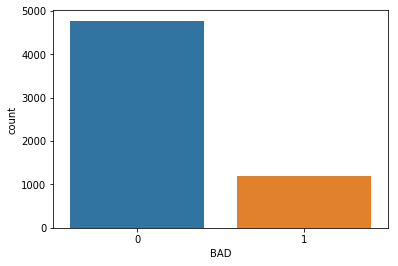

In [8]:
sns.countplot(data.BAD)

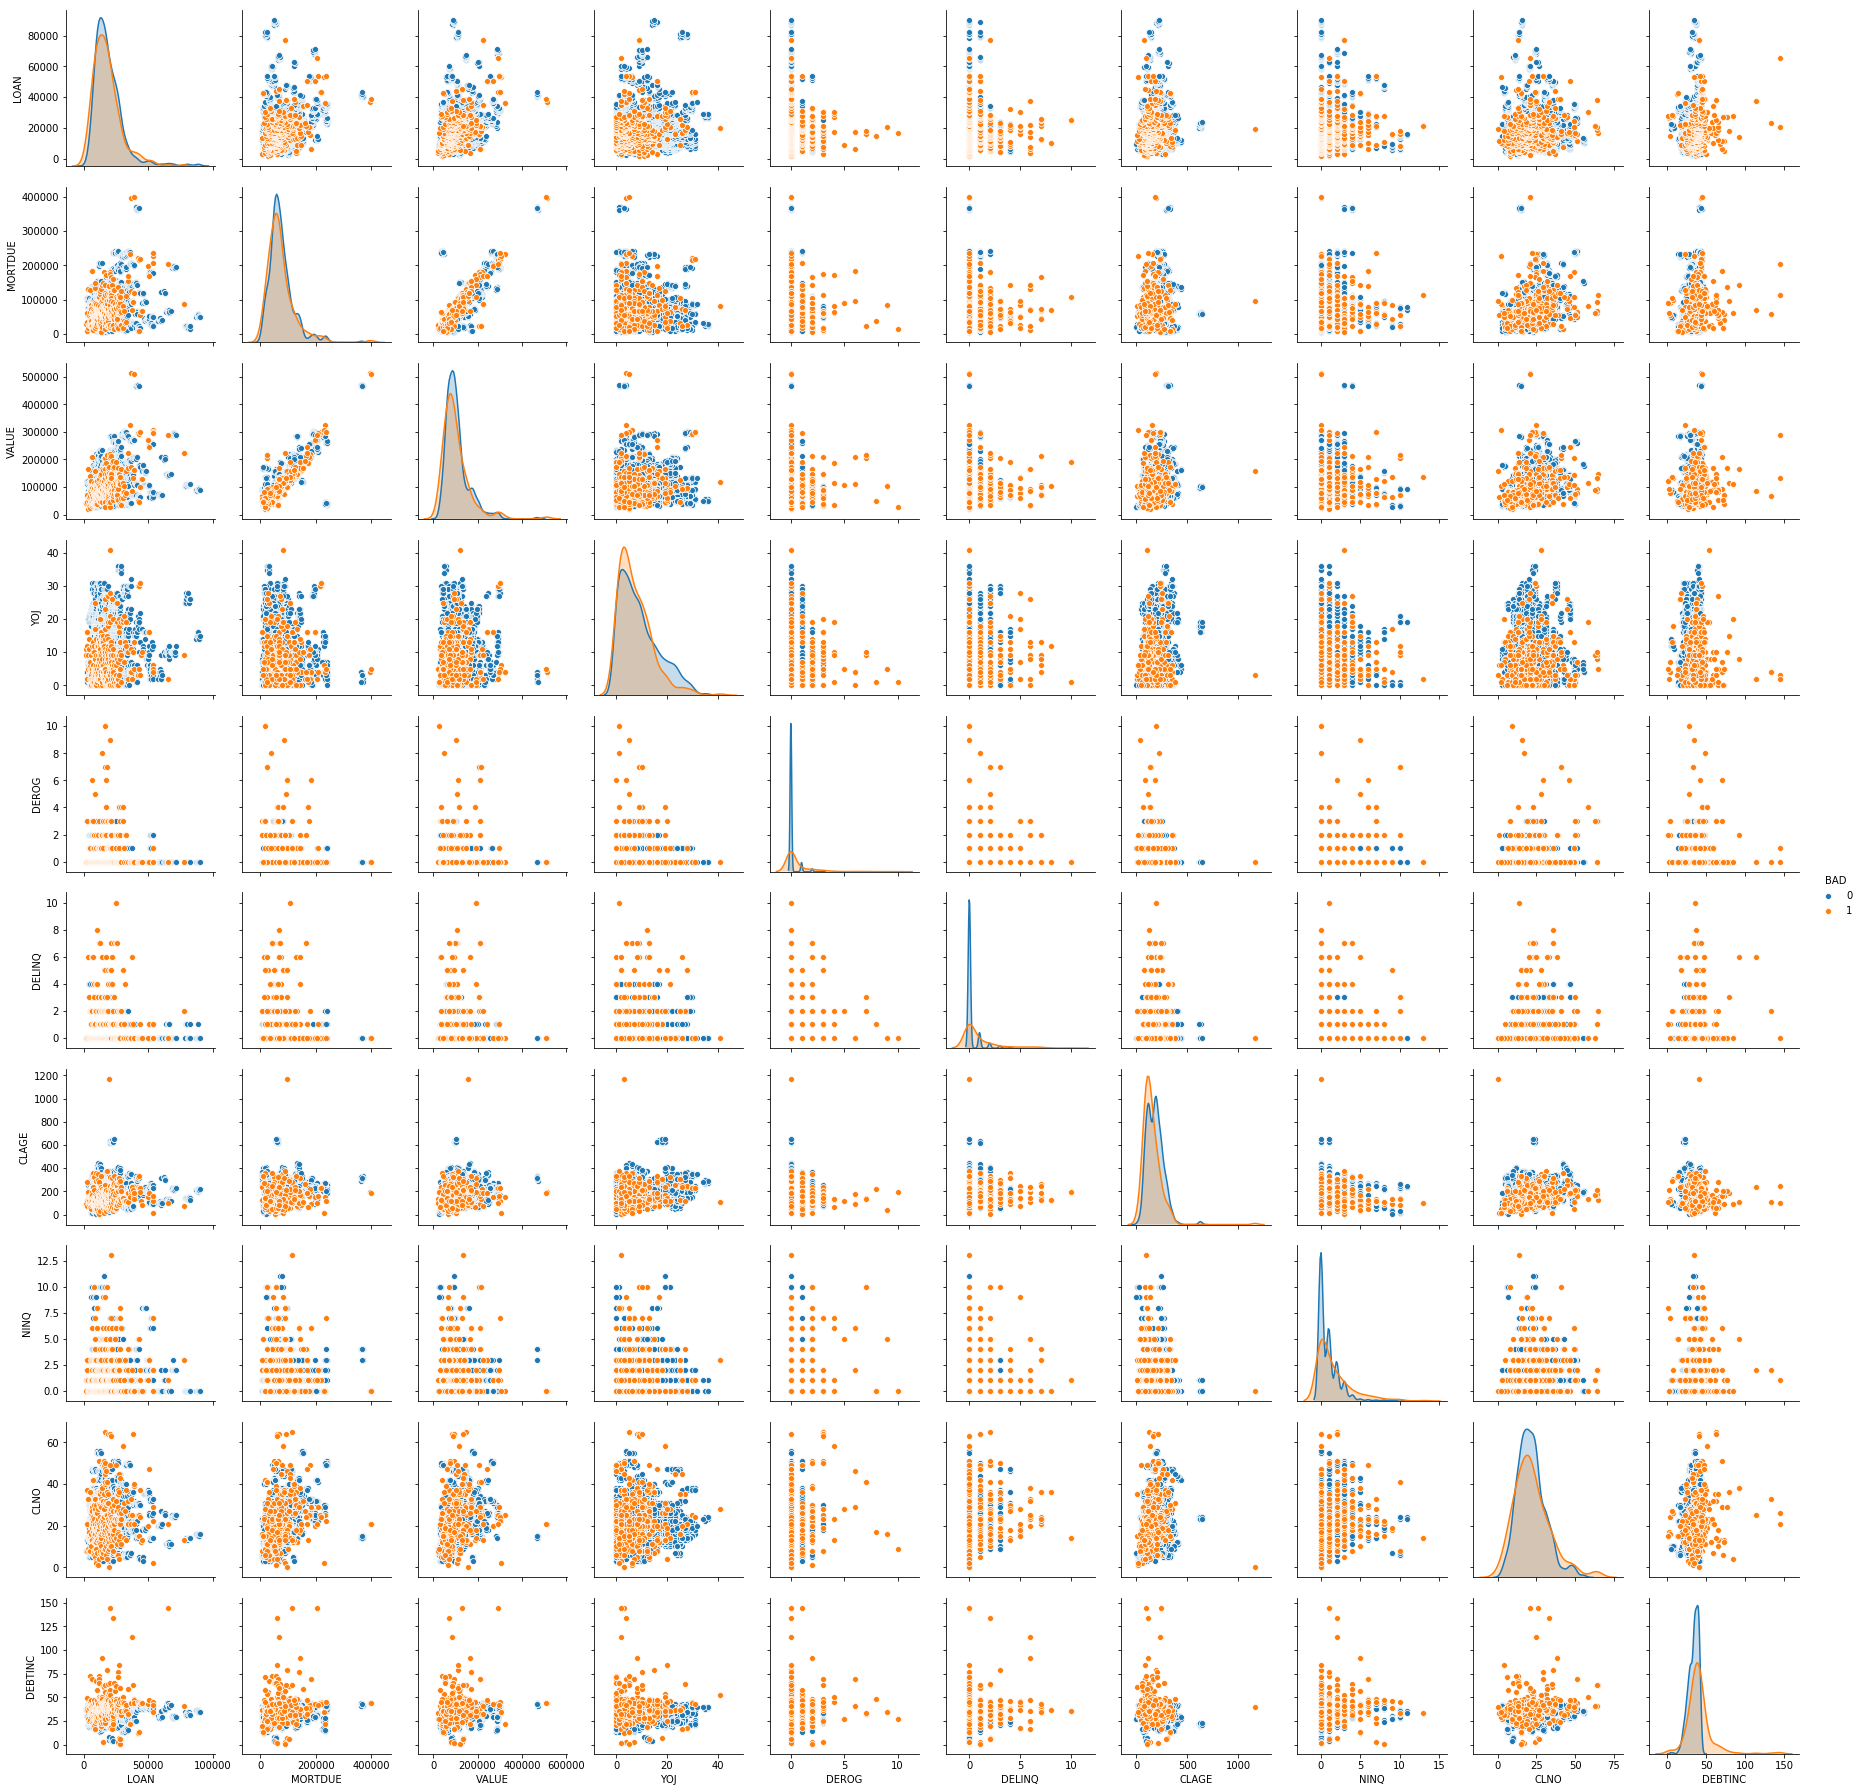

In [199]:
sns.pairplot(data._get_numeric_data().dropna(),hue='BAD',vars=data._get_numeric_data().columns[1:])

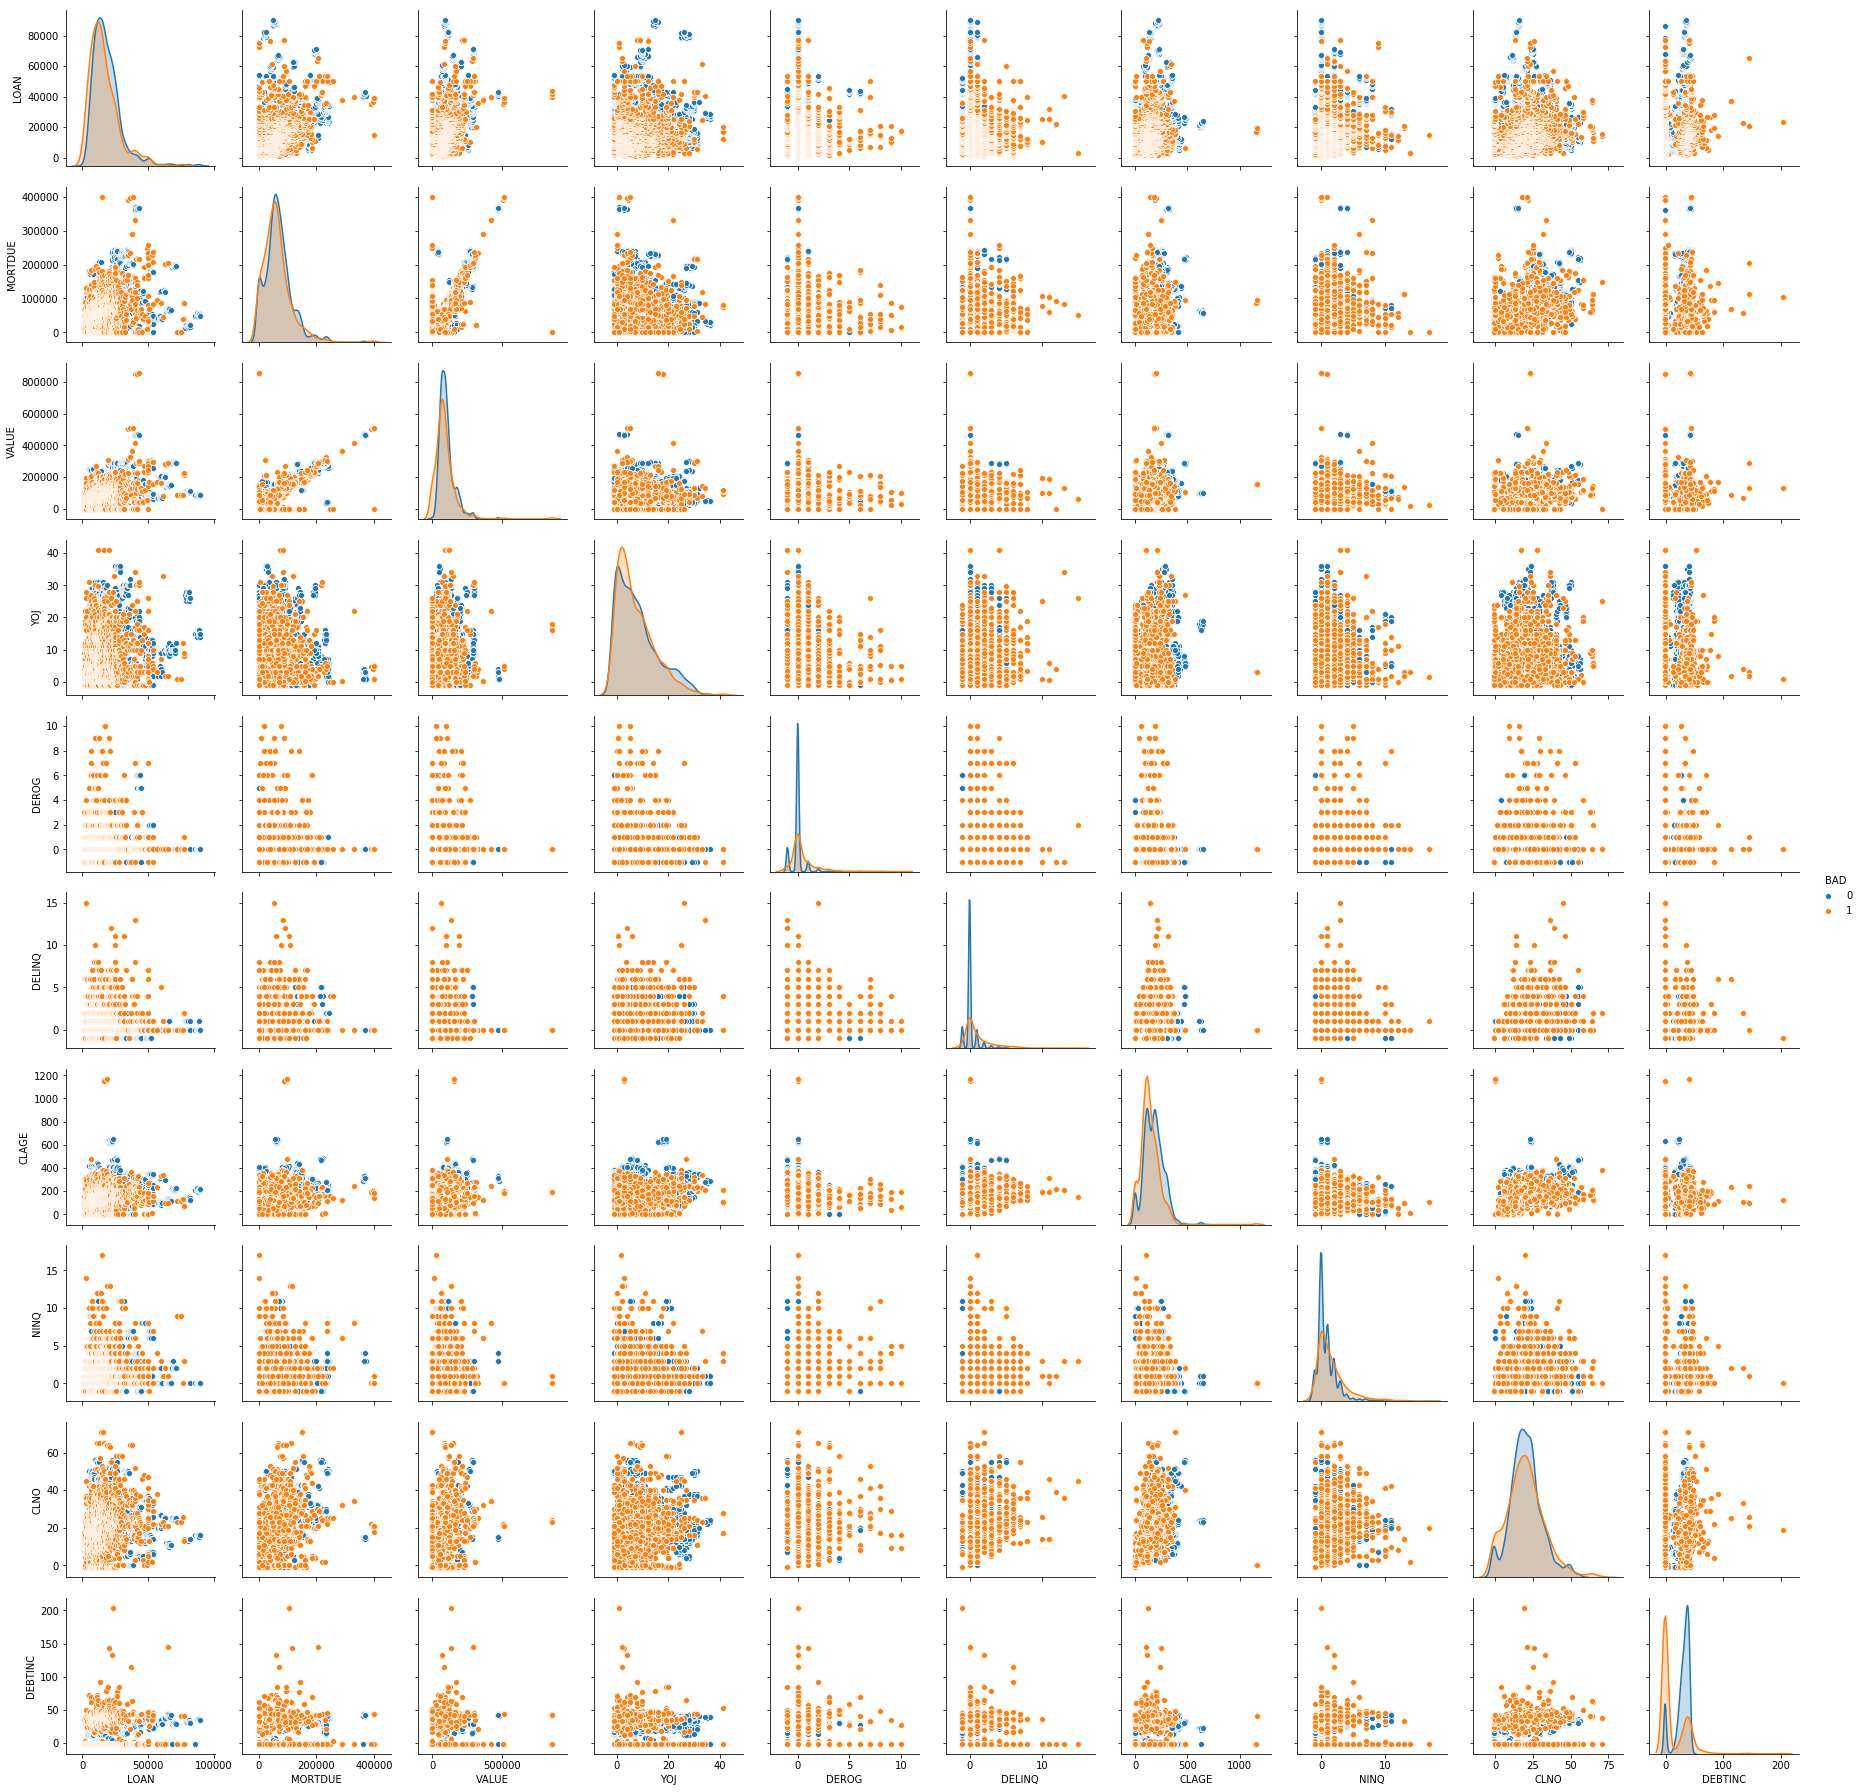

In [200]:
sns.pairplot(data._get_numeric_data().fillna(-1),hue='BAD',vars=data._get_numeric_data().columns[1:])

It seens that one of the most relevant variable is the debt to income ratio, and it exists a NULL value stucture that have to take into consideration when buildg the model

# Data Preparation

In [9]:
y = pd.Series(data.BAD)

In [10]:
X = pd.DataFrame(data.drop("BAD",axis=1))

In [11]:
X_train, X_test,y_train , y_test = train_test_split(X,y,stratify=y,test_size=0.15)

In [12]:
X_train, X_valid,y_train , y_valid = train_test_split(X_train,y_train,test_size=0.25)

For numeric features it will be use the median as replace of the missing values and for standarization it will be use MinMaxScaler given that when we have algos base in gradient decent optimization we got more stability in the training

In [13]:
numeric_features = data._get_numeric_data().columns[1:]
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

In [14]:
categorical_features = ['JOB', 'REASON']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())])

In [15]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

In [16]:
pipe_logistic_regression = Pipeline([
    ("preprocessing",preprocessor),
    ("clf",LogisticRegression(solver='lbfgs'))
])

In [17]:
pipe_XGBoost = Pipeline([
    ("preprocessing",preprocessor),
    ("clf",XGBClassifier())
])

In [18]:
pipe_NN = Pipeline([
    ("preprocessing",preprocessor),
    ("clf",MLPClassifier())
])

# Modeling

In [19]:
pipe_logistic_regression.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verb...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [20]:
pipe_XGBoost.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verb...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [21]:
pipe_NN.fit(X_train,y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verb...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

# Evaluation

In [22]:
def compare_model(legend_names=[],y_empirical=[], y_predicted=[] ,graphic_name=''):
    #is needed a pandas data frame
    for legend,y_hat in zip(legend_names,y_predicted):
        fpr, tpr , threshold = roc_curve(y_empirical,y_hat)
        roc_auc = auc(fpr, tpr)
        f1 = f1_score(y_empirical,y_hat)
        plt.title(graphic_name)
        plt.plot(fpr, tpr, label = '{} [AUC {:.2f},F1 {:.2f}]'.format(legend,roc_auc,f1))
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
    plt.show()


In [23]:
models = {
    'logistic':pipe_logistic_regression,
    'nn':pipe_NN,
    'xgboost':pipe_XGBoost
}

y_hat = []
for e in models:
    y_hat.append(models.get(e).predict(X_train))

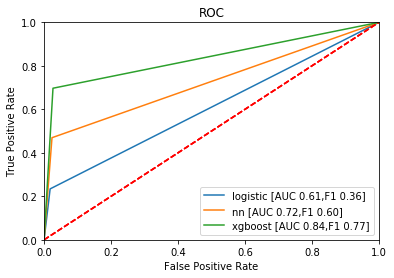

In [24]:
compare_model(models.keys(),y_train,y_hat,'ROC')

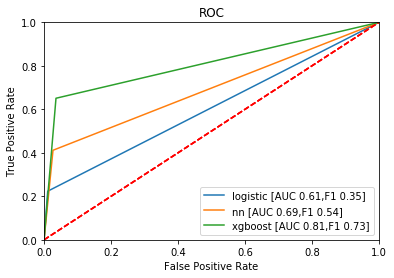

In [25]:
y_hat = []
for e in models:
    y_hat.append(models.get(e).predict(X_valid))
compare_model(models.keys(),y_valid,y_hat,'ROC')

In [ ]:
clf = DecisionTreeClassifier(random_state=76143)

# DONE: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'criterion':['gini','entropy'],'max_depth':[None,100,50,15,5,2],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}

# DONE: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# DONE: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# DONE: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_


# Deployment / Conclusion